In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [2]:
DATA_PATH = "/kaggle/input/office-script1/office_script_clean.txt"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    text = f.read()
text = text[:1_500_000]
print(f"using {len(text):,} chars")


using 1,500,000 chars


In [3]:
chars = sorted(set(text))
vocab_size = len(chars)

stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

def encode(s):
    return [stoi[c] for c in s]

def decode(ids):
    return "".join(itos[i] for i in ids)

print("vocab size:", vocab_size)


vocab size: 72


In [4]:
SEQ_LEN = 64

sequences = []
for i in range(0, len(text) - SEQ_LEN, SEQ_LEN):
    sequences.append(encode(text[i:i+SEQ_LEN+1]))

print(f"got {len(sequences):,} sequences")

split = int(0.9 * len(sequences))
train_seqs = sequences[:split]
val_seqs   = sequences[split:]

print(f"train: {len(train_seqs):,}, val: {len(val_seqs):,}")


got 23,437 sequences
train: 21,093, val: 2,344


In [5]:
EMB = 64
HID = 128

class CharLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, EMB)
        self.lstm = nn.LSTM(EMB, HID, batch_first=True)
        self.fc = nn.Linear(HID, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        return self.fc(out)

model = CharLSTM().to(DEVICE)
print(f"model: {EMB} -> {HID} -> {vocab_size}")


model: 64 -> 128 -> 72


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
criterion = nn.CrossEntropyLoss()

EPOCHS = 150
BATCH_SIZE = 24

print(f"epochs: {EPOCHS}, batch: {BATCH_SIZE}, lr: 0.006")


epochs: 150, batch: 24, lr: 0.006


In [7]:
hist = {"tp": [], "vp": []}
print("starting training")

for epoch in range(EPOCHS):
    warmup = 2
    if epoch < warmup:
        lr = 0.006 * (epoch + 1) / warmup
    else:
        p = (epoch - warmup) / (EPOCHS - warmup)
        lr = 0.001 + (0.006 - 0.001) * 0.5 * (1 + math.cos(math.pi * p))

    for g in optimizer.param_groups:
        g["lr"] = lr

    random.shuffle(train_seqs)

    
    nbatches = len(train_seqs) // BATCH_SIZE
    if nbatches == 0:
        nbatches = 1

    model.train()
    total_loss = 0.0

    for b in range(nbatches):
        batch = train_seqs[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        x = torch.tensor([s[:-1] for s in batch], device=DEVICE)
        y = torch.tensor([s[1:]  for s in batch], device=DEVICE)

        logits = model(x)
        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / nbatches
    train_ppl = math.exp(min(avg_loss, 10))

   
    if epoch < 2 or epoch % 5 == 0 or epoch == EPOCHS - 1:
        model.eval()
        with torch.no_grad():
            vl = 0.0
            for s in val_seqs[:50]:
                x = torch.tensor(s[:-1], device=DEVICE).unsqueeze(0)
                y = torch.tensor(s[1:],  device=DEVICE).unsqueeze(0)
                logits = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                vl += loss.item()
            vl /= 50
            val_ppl = math.exp(min(vl, 10))
    else:
        val_ppl = hist["vp"][-1]

    hist["tp"].append(train_ppl)
    hist["vp"].append(val_ppl)

    print(f"epoch {epoch+1}/{EPOCHS}: ppl={train_ppl:.2f}, val={val_ppl:.2f}, lr={lr:.4f}")

print(f"\nbest val ppl: {min(hist['vp']):.2f}")


starting training
epoch 1/150: ppl=6.13, val=3.92, lr=0.0030
epoch 2/150: ppl=4.48, val=3.53, lr=0.0060
epoch 3/150: ppl=4.13, val=3.53, lr=0.0060
epoch 4/150: ppl=3.98, val=3.53, lr=0.0060
epoch 5/150: ppl=3.90, val=3.53, lr=0.0060
epoch 6/150: ppl=3.84, val=3.29, lr=0.0060
epoch 7/150: ppl=3.80, val=3.29, lr=0.0060
epoch 8/150: ppl=3.76, val=3.29, lr=0.0060
epoch 9/150: ppl=3.74, val=3.29, lr=0.0060
epoch 10/150: ppl=3.72, val=3.29, lr=0.0060
epoch 11/150: ppl=3.70, val=3.20, lr=0.0060
epoch 12/150: ppl=3.68, val=3.20, lr=0.0060
epoch 13/150: ppl=3.68, val=3.20, lr=0.0059
epoch 14/150: ppl=3.67, val=3.20, lr=0.0059
epoch 15/150: ppl=3.66, val=3.20, lr=0.0059
epoch 16/150: ppl=3.65, val=3.15, lr=0.0059
epoch 17/150: ppl=3.64, val=3.15, lr=0.0059
epoch 18/150: ppl=3.64, val=3.15, lr=0.0059
epoch 19/150: ppl=3.63, val=3.15, lr=0.0059
epoch 20/150: ppl=3.62, val=3.15, lr=0.0058
epoch 21/150: ppl=3.62, val=3.12, lr=0.0058
epoch 22/150: ppl=3.61, val=3.12, lr=0.0058
epoch 23/150: ppl=3.61,

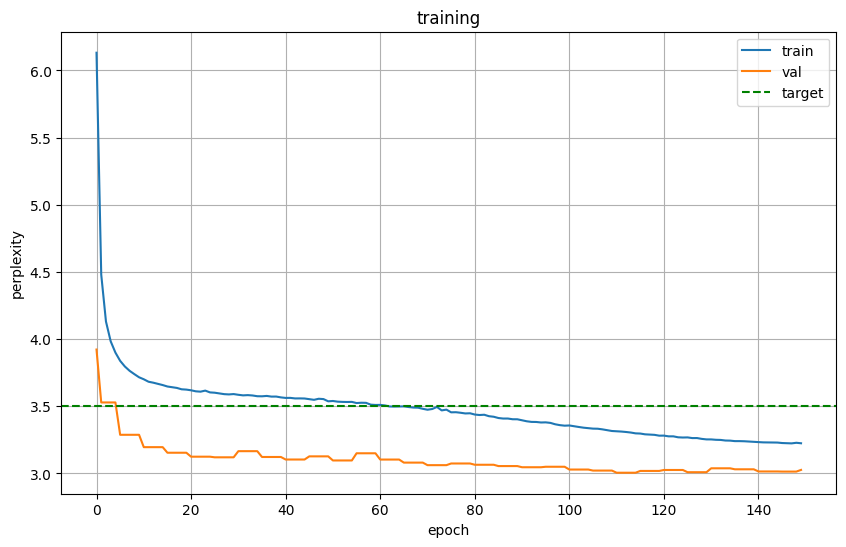

In [8]:
plt.figure(figsize=(10,6))
plt.plot(hist["tp"], label="train")
plt.plot(hist["vp"], label="val")
plt.axhline(3.5, color="green", linestyle="--", label="target")
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.title("training")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
def generate(seed_text, temp=0.7, steps=500):
    model.eval()
    seed = encode(seed_text)
    h = None
    x = torch.tensor(seed, device=DEVICE).unsqueeze(0)

    with torch.no_grad():
        for _ in range(steps):
            emb = model.embed(x)
            out, h = model.lstm(emb, h)
            logits = model.fc(out[:, -1])
            probs = F.softmax(logits / temp, dim=-1)
            idx = torch.multinomial(probs, 1)
            x = torch.cat([x, idx], dim=1)

    return seed_text + decode(x[0].tolist()[len(seed):])


In [10]:
seed = "Michael: Hey Shaurya, get lost asap!"
temps = [0.3, 0.7, 1.0]

for t in temps:
    print("\nTemperature:", t)
    print("-" * 70)
    print(generate(seed, temp=t)[:400])



Temperature: 0.3
----------------------------------------------------------------------
Michael: Hey Shaurya, get lost asap! 
Jim: Yeah.
Michael: What are you doing?
Michael: I don't know.
Dwight: Well, I would like to say that you don't want to do this. I would like to be a big day.
Michael: What are you doing?
Michael: What are you doing?
Michael: What are you doing?
Michael: Yes.
Dwight: What are you doing?
Jim: Okay, I don't know how to be a single because I want to see you the t

Temperature: 0.7
----------------------------------------------------------------------
Michael: Hey Shaurya, get lost asap! I'll do this.
Michael: I have to do is that you can use. When I have gotten harded a donkey food. I guess I were people as you do that controlm. That's unbelieve. I am thinking about now about it. I was already forgot? What about that. I am going to like it, let's get back back believed enough in the month people.
Michael: How could I appreciate my going to get

Temperature: 1.0
--